In [1]:
##导入所需要的各种库
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import talib
from collections import deque
import scipy.stats as st
from sklearn.linear_model import LinearRegression
from arch.unitroot import ADF
import statsmodels.api as sm

In [2]:
# 获取国内期货日行情信息
tam0 = pd.read_csv('tam0.csv')
rum0 = pd.read_csv('rum0.csv')
tam0 = tam0.dropna()
rum0 = rum0.dropna()
tam0.index=pd.to_datetime(tam0.tradeDate) ##把tradeDate列变成时间索引格式
rum0.index=pd.to_datetime(rum0.tradeDate)
tam0.sort_index(inplace=True)  ##把数据按照时间先后排序，因为有可能获取出的数据顺序是混乱的
rum0.sort_index(inplace=True)

In [3]:
print(tam0)
print(rum0)

            Unnamed: 0  closePrice   tradeDate
tradeDate                                     
2014-10-08           0        3071  2014-10-08
2014-10-09           1        3110  2014-10-09
2014-10-10           2        3091  2014-10-10
2014-10-13           3        3114  2014-10-13
2014-10-14           4        3155  2014-10-14
...                ...         ...         ...
2017-06-14         655        3270  2017-06-14
2017-06-15         656        3269  2017-06-15
2017-06-16         657        3270  2017-06-16
2017-06-19         658        3270  2017-06-19
2017-06-20         659        3259  2017-06-20

[660 rows x 3 columns]
            Unnamed: 0  closePrice   tradeDate
tradeDate                                     
2014-10-08           0        5922  2014-10-08
2014-10-09           1        5980  2014-10-09
2014-10-10           2        5910  2014-10-10
2014-10-13           3        5900  2014-10-13
2014-10-14           4        5992  2014-10-14
...                ...         ...  

In [4]:
y = np.array(tam0['closePrice'])
x1 = np.array(rum0['closePrice'])
log_y = np.log(y)
log_x1 = np.log(x1)  ##数据对数化，为了避免异方差和共线性的影响

In [5]:
adfTA = ADF(log_y) ##检查对数序列是否平稳
print(adfTA.summary().as_text())
##原假设是含有单位根，T值小于临界值为拒绝域，在临界值内接受原假设

   Augmented Dickey-Fuller Results   
Test Statistic                 -1.468
P-value                         0.549
Lags                                3
-------------------------------------

Trend: Constant
Critical Values: -3.44 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


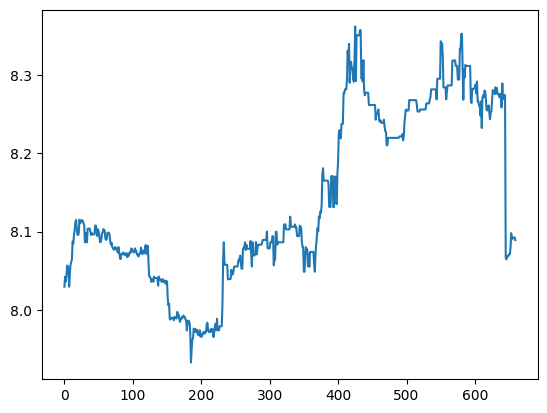

In [6]:
plt.figure()
plt.plot(log_y)
plt.show()

In [7]:
retTA = np.diff(log_y)##原序列不平稳，做差分后，看是否平稳，若不平稳接着差分
adfretTA = ADF(retTA)
print(adfretTA.summary().as_text())

   Augmented Dickey-Fuller Results   
Test Statistic                -16.836
P-value                         0.000
Lags                                2
-------------------------------------

Trend: Constant
Critical Values: -3.44 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


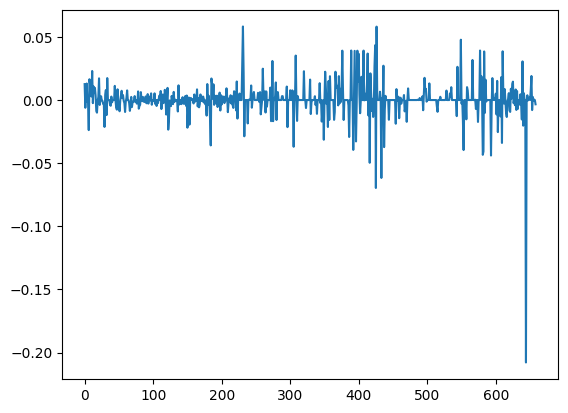

In [8]:
plt.figure()
plt.plot(retTA)
plt.show()

In [9]:
adfMA = ADF(log_x1)##与前面同样的操作
print(adfMA.summary().as_text())

   Augmented Dickey-Fuller Results   
Test Statistic                 -1.727
P-value                         0.417
Lags                                2
-------------------------------------

Trend: Constant
Critical Values: -3.44 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [10]:
retMA = np.diff(log_x1)
adfretMA = ADF(retMA)
print(adfretMA.summary().as_text())

   Augmented Dickey-Fuller Results   
Test Statistic                -19.353
P-value                         0.000
Lags                                1
-------------------------------------

Trend: Constant
Critical Values: -3.44 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [11]:
model = sm.OLS(log_y,sm.add_constant(log_x1)) ##对差分后的序列做线性回归
results = model.fit()
print(results.summary()) ##查看回归结果

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.601
Model:                            OLS   Adj. R-squared:                  0.600
Method:                 Least Squares   F-statistic:                     989.2
Date:                Mon, 20 Dec 2021   Prob (F-statistic):          3.10e-133
Time:                        17:47:22   Log-Likelihood:                 821.48
No. Observations:                 660   AIC:                            -1639.
Df Residuals:                     658   BIC:                            -1630.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.6468      0.311     -5.291      0.0

In [12]:
alpha = results.params[0] ##取模型的常数项
beta = results.params[1]  ##取模型的系数项
spread = log_y - beta*log_x1 - alpha ##求残差
adfSpread = ADF(spread,trend='nc')   ##看残差是否平稳，平稳说明提取了大部分信息，模型效果较好
print(adfSpread.summary().as_text())
print(alpha,beta)

   Augmented Dickey-Fuller Results   
Test Statistic                 -2.965
P-value                         0.003
Lags                                2
-------------------------------------

Trend: No Trend
Critical Values: -2.57 (1%), -1.94 (5%), -1.62 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
-1.6467819717120369 1.126251106795413


/home/quant/opt/anaconda3/envs/quant/lib/python3.7/site-packages/arch/unitroot/unitroot.py:488: FutureWarning: Trend "nc" is deprecated and has been replaced with "n" (for none).
  FutureWarning,


In [13]:
###画图
fig = plt.figure(figsize=(12,5))
sns.set_style('whitegrid')
ax = fig.add_subplot(111)
ax.set_xlim(0, len(tam0))
ax.plot(log_y, color = '#000000',label='A',lw=3)
ax.plot(log_x1, 'r', label='Y', lw=3)
ax.set_xticks(range(0, len(tam0),60))
ax.legend(loc=1)
xlabel = ax.set_xticklabels([tam0.ix[i,'tradeDate'] for i in ax.get_xticks()])              
title = ax.set_title(u'价格历史走势图', loc=u'center', fontproperties=font, fontsize=16)  
plt.show()

AttributeError: 'DataFrame' object has no attribute 'ix'

In [ ]:
##计算价差的均值、标准差，并设置不同的上下轨
mu = np.mean(spread)
sd = np.std(spread)
upper,lower = mu+0.3*sd,mu-0.3*sd
upper1,lower1 = mu+0.8*sd,mu-0.8*sd
upper2,lower2 = mu+1.8*sd,mu-1.8*sd

In [ ]:
##画出价差走势及不同阈值线
fig = plt.figure(figsize=(12,5))
sns.set_style('whitegrid')
ax = fig.add_subplot(111)
ax.set_xlim(0, len(tam0))

ax.plot(spread,lw=3)
ax.plot([mu]*len(spread), '-r')
ax.plot([upper]*len(spread), '--b')
ax.plot([lower]*len(spread), '--b')
ax.plot([upper1]*len(spread), '--g')
ax.plot([lower1]*len(spread), '--g')
ax.plot([upper2]*len(spread), '--r')
ax.plot([lower2]*len(spread), '--r')
ax.set_xticks(range(0, len(spread),60))
xlabel = ax.set_xticklabels([tam0.ix[i,'tradeDate'] for i in ax.get_xticks()])
title = ax.set_title(u'价差历史走势图', loc=u'center', fontproperties=font, fontsize=16)

In [ ]:
yt = np.array(tam0['closePrice'])
x1t = np.array(rum0['closePrice'])
log_yt = np.log(yt)
log_x1t = np.log(x1t)
CoSpreadT = log_y - beta*log_x1 - alpha 

In [ ]:
#####模拟交易账户
level =  (float('-inf'),lower2,lower1,lower,upper,upper1, upper2,float('inf'))  ##根据指定的数值划分实数区间
prcLevel = pd.cut(CoSpreadT,level,labels=False)-3  ##位于第一个区间返回0，第二个区间返回1，依次类推

def TradeSig(prcLevel):
    n = len(prcLevel)
    signal = np.zeros(n)
    for i in range(1,n):
        if prcLevel[i-1]==1 and prcLevel[i]==2:
            signal[i]=-2
        elif prcLevel[i-1]==1 and prcLevel[i]==0:
            signal[i]=2
        elif prcLevel[i-1]==1 and prcLevel[i]==-1:
            signal[i]=2
        elif prcLevel[i-1]==1 and prcLevel[i]==-2:
            signal[i]=4
        elif prcLevel[i-1]==2 and prcLevel[i]==-2:
            signal[i]=4
        elif prcLevel[i]==3:
            signal[i]=3
        elif prcLevel[i-1]==-1 and prcLevel[i]==-2:
            signal[i]=1
        elif prcLevel[i-1]==-1 and prcLevel[i]==0:
            signal[i]=-1
        elif prcLevel[i-1]==-1 and prcLevel[i]==1:
            signal[i]=-1
        elif prcLevel[i-1]==-1 and prcLevel[i]==2:
            signal[i]=-4
        elif prcLevel[i-1]==-2 and prcLevel[i]==2:
            signal[i]=-4
        elif prcLevel[i]==-3:
            signal[i]=-3
    return(signal)

In [ ]:
Signal = TradeSig(prcLevel)
position = [Signal[0]]
ns = len(Signal)
for i in range(1,ns):
    position.append(position[-1])
    if Signal[i]==1:  ##下穿-0.7*sd
        position[i]=1
    elif Signal[i]==-2:  ##上穿+0.7*sd
        position[i]=-1
    elif Signal[i]==-1 and position[i-1]==1: ##下穿-0.7*sd，到上穿至-0.3*sd或0.3*sd
        position[i]=0
    elif Signal[i]==2 and position[i-1]==-1: ##下穿-0.7*sd，到上穿至-0.3*sd或0.3*sd，又下穿一条或两条线
        position[i]=0
    elif Signal[i]==3: ##在最上轨之上
        position[i]=0
    elif Signal[i]==-3:#在最下轨之下
        position[i]=1
    elif Signal[i]==4:##从上第二轨或第三轨下穿至倒数第二轨之下
        position[i]=1
    elif Signal[i]==-4:##从倒数第二轨上穿至第二轨或第三轨之上
        position[i]=-1

In [ ]:
position = pd.Series(position,index=tam0.index)
positionY = position
position.tail()

In [ ]:
def TradeSim(priceX,priceY,position):
    n=len(position)
    sizeX=5
    sizeY=10
    shareY=sizeY*positionY
    shareX=[(-beta)*shareY[0]*priceY[0]/priceX[0]]
    positionX=[shareX[0]/sizeX]
    cash=[3000]
    for i in range(1,n):
        shareX.append(shareX[i-1])
        cash.append(cash[i-1])
        positionX.append(positionX[i-1])
        if position[i-1]==0 and position[i]==1:
            shareX[i]=(-beta)*shareY[i]*priceY[i]/priceX[i]
            cash[i]=cash[i-1]-(shareY[i]*priceY[i]+shareX[i]*priceX[i])
        elif position[i-1]==0 and position[i]==-1:
            shareX[i]=(-beta)*shareY[i]*priceY[i]/priceX[i]
            cash[i]=cash[i-1]-(shareY[i]*priceY[i]+shareX[i]*priceX[i])
        elif position[i-1]==1 and position[i]==0:
            shareX[i]=0
            cash[i]=cash[i-1]+(shareY[i-1]*priceY[i]+shareX[i-1]*priceX[i])
        elif position[i-1]==-1 and position[i]==0:
            shareX[i]=0
            cash[i]=cash[i-1]+(shareY[i-1]*priceY[i]+shareX[i-1]*priceX[i])
        elif position[i-1]==1 and position[i]==-1:#先做空平仓，在做空开新仓
            shareX[i]=(-beta)*shareY[i]*priceY[i]/priceX[i]
            cash1=cash[i-1]+(shareY[i-1]*priceY[i]+shareX[i-1]*priceX[i])
            cash[i]=cash1-(shareY[i]*priceY[i]+shareX[i]*priceX[i])
        elif position[i-1]==-1 and position[i]==1:#先做多平仓，在做多开新仓
            shareX[i]=(-beta)*shareY[i]*priceY[i]/priceX[i]
            cash1=cash[i-1]+(shareY[i-1]*priceY[i]+shareX[i-1]*priceX[i])
            cash[i]=cash1-(shareY[i]*priceY[i]+shareX[i]*priceX[i])
        positionX[i]=shareX[i]/sizeX
    cash = pd.Series(cash, index=tam0.index)
    shareY = pd.Series(shareY, index=tam0.index) 
    shareX = pd.Series(shareX, index=tam0.index)
    positionX = pd.Series(positionX, index=tam0.index)
    asset = cash + shareY*priceY + shareX*priceX
    account =pd.DataFrame({'PositionX':positionX,'shareX':shareX,'PositionY':positionY,
                           'shareY':shareY,'Cash':cash,'Asset':asset})
    return(account)

In [ ]:
Account = TradeSim(x1t,yt,position)
plt.figure()
print(Account.tail())
plt.show()
plt.figure()
Account.iloc[:,(0,1)].plot(figsize=(12,4))
print(beta)
Account.iloc[:,(2,3)].plot(figsize=(12,4))
plt.show()